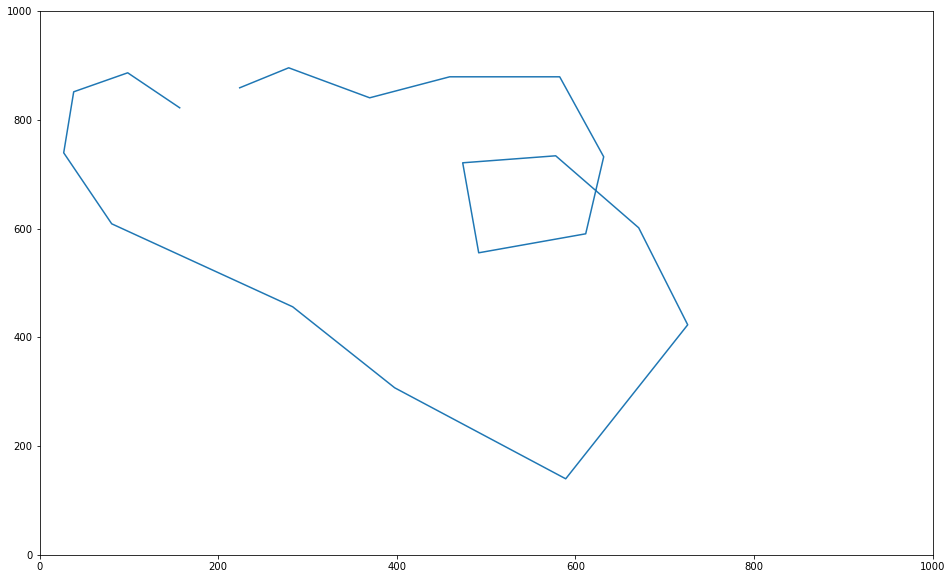

In [12]:
"""
This function takes point input from the user
"""

import matplotlib
import matplotlib.pyplot as plt


matplotlib.use('TkAgg')


def draw_line():
    ax = plt.gca()
    xy = plt.ginput(20)
    x = [p[0] for p in xy]
    y = [p[1] for p in xy]
    line = plt.plot(x, y)
    ax.figure.canvas.draw()
    return xy
    
fig = plt.figure(figsize=(16, 10))
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.show()


points = draw_line()
nodes = [list(ele) for ele in points]

In [13]:
import math
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

import warnings; 

warnings.simplefilter('ignore')

%matplotlib inline

seg = 400
direction = 0

"""
Creates an interpolated spline
"""
def spline(points, smoothness=2,segments=seg):
    points = np.array(points)
    px = points[:,0]
    py = points[:,1]
#     px = np.r_[px, px[0]]
#     py = np.r_[py, py[0]]
    ptck,u = interpolate.splprep( [px,py] ,s = smoothness,per=True)
    pxnew,pynew = interpolate.splev( np.linspace( 0, 1, segments), ptck)
    return [pxnew,pynew]

xnew, ynew = spline(nodes)

def get_points_on_line(x, y, dist, slope):
    dx = dist / math.sqrt(1+(slope * slope))
    dy = slope * dx
    return [x+dx, y+dy]

"""
This function is to evaluate which side of a line a point lies
"""
def isLeft(a, b, c):
     return (b[0] - a[0])*(c[1] - a[1]) > (b[1] - a[1])*(c[0] - a[0]);
    

"""
This function is for evaluating the inner and outer track points
"""
def evaluate_order(inner, outer, tan1, tan2, normal): 
    if isLeft(tan1,tan2, normal):
        inner.append(normal)
    else:
        outer.append(normal)
    return [inner, outer]

"""
This function evaluates the direction of a given line
"""
def line_with_direction(x,y,l,s,prev):
    pt1 = get_points_on_line(x, y, -l, s)
    pt2 = get_points_on_line(x, y, l, s)
    if (
        (nodes[0][0] > nodes[1][0] and math.dist(pt1,prev) > math.dist(pt2,prev)) 
        or (nodes[0][0] < nodes[1][0] and math.dist(pt1,prev) < math.dist(pt2,prev))
       ):
        direction = 0
        return [pt1,pt2]
    else:
        direction = 1
        return [pt2,pt1]

"""
Generates the sample squares
"""
def generate_squares(width,step=2):
    previous=[0,0]
    sub_sample_x = xnew[0::step]
    squares = []
    for idx,x_to_use in enumerate(sub_sample_x):

        x0 = x_to_use
        i0 = np.argmin(np.abs(xnew-x0))
        x1 = xnew[i0:i0+2]
        y1 = ynew[i0:i0+2]
        dydx = np.diff(y1)/np.diff(x1)
        
        tngnt = lambda v: dydx*v + (y1[0]-dydx*x1[0])
        tan_y=tngnt(xnew)

        y_to_use = tan_y[np.where(xnew == x_to_use)[0][0]]

        slope, intercept, r, p, se = linregress(xnew,tan_y)

        if idx != 0:
            tan1,tan2 = line_with_direction(x_to_use, y_to_use, 20, slope, previous)
        else:
            tan1 = get_points_on_line(x_to_use, y_to_use, -20, slope)
            tan2 = get_points_on_line(x_to_use, y_to_use, 20, slope)

        inv_recip_slope = -1/slope

        normal1,normal2 = line_with_direction(x_to_use, y_to_use, width, inv_recip_slope, previous)

        tana, tanb = line_with_direction(*normal1, width, slope, previous)
        tanc, tand = line_with_direction(*normal2, width, slope, previous)
        square = [tana,tanc,tand,tanb,tana]
        squares.append(square)
        previous = [x_to_use, y_to_use]
    return squares
    

"""
Generates the track
"""
def track(width,show_normals=False):
    inner = []
    outer = []
    previous=[0,0]
    sub_sample_x = xnew[0::5]
    for idx,x_to_use in enumerate(sub_sample_x):
        x0 = x_to_use
        i0 = np.argmin(np.abs(xnew-x0))
        x1 = xnew[i0:i0+2]
        y1 = ynew[i0:i0+2]
        dydx = np.diff(y1)/np.diff(x1)
        tngnt = lambda v: dydx*v + (y1[0]-dydx*x1[0])
        tan_y=tngnt(xnew)

        y_to_use = tan_y[np.where(xnew == x_to_use)[0][0]]

        slope, intercept, r, p, se = linregress(xnew,tan_y)

        if idx != 0:
            tan1,tan2 = line_with_direction(x_to_use, y_to_use, 20, slope, previous)
        else:
            tan1 = get_points_on_line(x_to_use, y_to_use, -20, slope)
            tan2 = get_points_on_line(x_to_use, y_to_use, 20, slope)

        inv_recip_slope = -1/slope

        normal1,normal2 = line_with_direction(x_to_use, y_to_use, width, inv_recip_slope, previous)
        inner, outer = evaluate_order(inner, outer,tan1,tan2,normal1)
        inner, outer = evaluate_order(inner, outer,tan1,tan2,normal2)
        if show_normals:
            normies = np.asarray([normal1,normal2])
            plt.plot(normies[:,0],normies[:,1])
        previous = [x_to_use, y_to_use]
    inner_track = spline(inner)
    outer_track = spline(outer)
    return [inner_track,outer_track]    

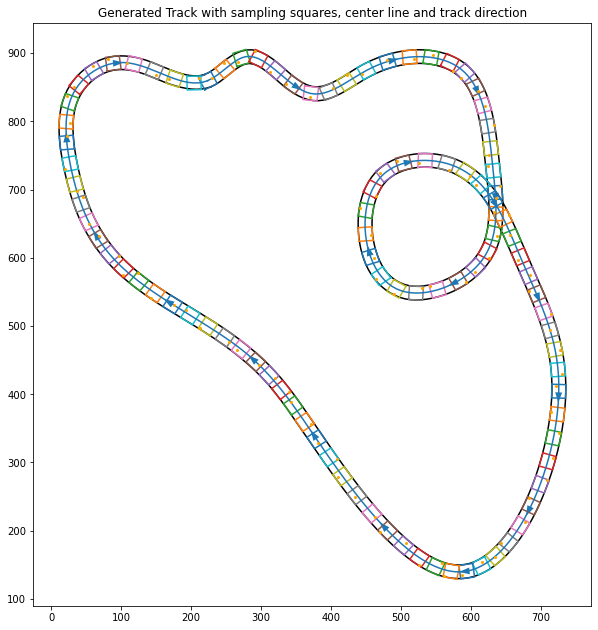

In [31]:
from shapely.geometry import Polygon, Point
import random

"""
Generates a random point within given polygon points
"""
def random_point_within(points):
    poly = Polygon(points)
    min_x, min_y, max_x, max_y = poly.bounds
    found_point = []
    while len(found_point) != 1:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            found_point.append(random_point)
    return found_point[0]

control_points = 200

"""
Creates random control points in the tracks sample squares and interpolates a spline
"""
def generate_random_spline(in_squares):
    points = []
    for square in in_squares:
        pt = random_point_within(square)
        points.append([pt.x,pt.y])
    spx,spy = spline(points, smoothness=3000, segments=control_points )
    c_points = np.asarray(points)
    return ([spx,spy], c_points)

figure_width = 10
ratio =  (abs(max(ynew))-abs(min(ynew))) / (abs(max(xnew))-abs(min(xnew)))
figure_height = figure_width * ratio
plt.rcParams["figure.figsize"] = (figure_width,figure_height)

track_width = 10

inner_track, outer_track = track(track_width)
plt.plot(*inner_track, color='black')
plt.plot(*outer_track,  color='black')

squares = generate_squares(track_width, 4)
for square in squares:
    square = np.asarray(square)
    plt.plot(square[:,0],square[:,1])

"""
This funtion figures out the direction of track for visualisation
"""
def track_direction(inx,iny):
    distx = 2
    if direction == 1:
        distx = -distx
    disty = distx
    
    for idx, x in enumerate(inx):
        if idx != 0 and idx % 20 == 0:
            plt.arrow(x, iny[idx], inx[idx+distx]-x, iny[idx+disty]-iny[idx], head_width=10,shape='full', lw=0, length_includes_head=True)

        
track_direction(xnew ,ynew)
plt.plot(xnew ,ynew)
racing_line, c_points = generate_random_spline(squares)
plt.plot(c_points[:,0],c_points[:,1],'o',markersize=2, color='orange')
plt.title("Generated Track with sampling squares, center line and track direction")
plt.show()

In [32]:
from math import sqrt
from sympy import symbols, solve

"""
This function is for calculating the radius of curvature
"""
# https://towardsdatascience.com/an-advanced-guide-to-aws-deepracer-2b462c37eea
# Input 3 coords [[x1,y1],[x2,y2],[x3,y3]]
def circle_radius(coords):

    # Flatten the list and assign to variables
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999

    return r

"""
This function generates a race line given a distance and max velocity and returns the racing line
control points, time taken and velocity
"""
def generate_race_line(max_vel=25, dist=5800, gen=0):
    if gen == 0:
        new_racing_line, c_points = generate_random_spline(squares)
    else:
        new_racing_line, c_points = gen

    radii = []
    vels = []
    for idx, point in enumerate(zip(*new_racing_line)):
        if idx == 0:
            prev_point = (new_racing_line[0][control_points-1],new_racing_line[0][control_points-1])
        else:
            prev_point = (new_racing_line[0][idx-1],new_racing_line[0][idx-1])

        if idx == control_points-1:
            next_point = (new_racing_line[0][1],new_racing_line[0][1])
        else:
            next_point = (new_racing_line[0][idx+1],new_racing_line[0][idx+1])

        radius = circle_radius([point,prev_point, next_point])
        radii.append(radius)
        c = 1.3 * sqrt(radius)
        if c > max_vel:
            vels.append(max_vel)
        else:
            vels.append(c)
      
    time = dist / np.mean(vels)
    return [new_racing_line, vels, time, c_points]

Text(0.5, 1.0, 'Track with veocity')

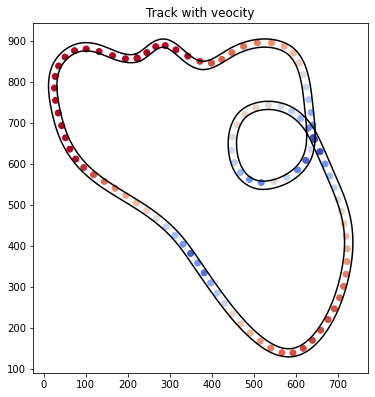

In [115]:
rl, v, t, c = generate_race_line()

figure_width = 6
ratio =  (abs(max(ynew))-abs(min(ynew))) / (abs(max(xnew))-abs(min(xnew)))
figure_height = figure_width * ratio
plt.rcParams["figure.figsize"] = (figure_width,figure_height)

rx = rl[0]
ry = rl[1]
fig, ax = plt.subplots()
ax.scatter(rx, ry, c=v, cmap=plt.cm.coolwarm);
plt.plot(*inner_track, color='black')
plt.plot(*outer_track,  color='black')
plt.title("Track with veocity")

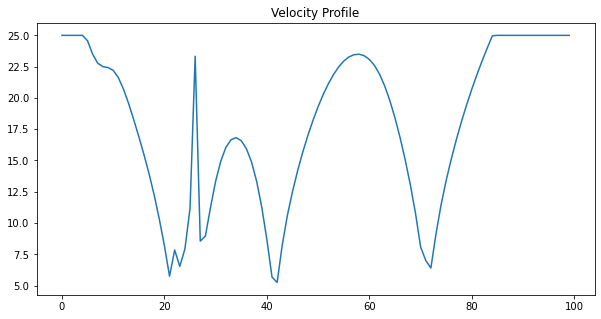

In [114]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(v)
plt.title("Velocity Profile")
plt.show()

In [109]:
from operator import itemgetter

"""
This function randomly generates tracks for later evaluation against genetic algorithm
"""
def random_gen(n_iter, n_pop):
    all_the_best = []
    all_the_worst = []
    gen_avg = []
    best = [0,0,10000]
    for gen in range(n_iter):
        if gen % 10 == 0:
            print(gen, ' epochs completed')
        population = [generate_race_line() for _ in range(n_pop)]
        pop_s = sorted(population,key=itemgetter(2))
        if pop_s[0][2] < best[2]:
            best = pop_s[0]
        all_the_best.append(pop_s[0])
        all_the_worst.append(pop_s[-1])
        times = [idv[2] for idv in pop_s]
        gen_avg.append(np.mean(times))
    
    best_time_avg = np.mean([idv[2] for idv in all_the_best])
    worst_time_avg = np.mean([idv[2] for idv in all_the_worst])
    avg = np.mean(gen_avg)
    print(f"Random generated racing lines with {n_iter} gen and population of {n_pop}")
    print(n_iter*n_pop, "racing lines randomly generated")
    print("Best time: ", best[2])
    print("Average Best Time: ", best_time_avg)
    print("Average Worst Time: ", worst_time_avg)
    print("Average Time: ", rand_avg)
    return best_time_avg, worst_time_avg, avg, best[2]

In [112]:
rand_best_time_avg, rand_worst_time_avg, rand_avg, best_time = random_gen(50,500)

0  epochs completed
10  epochs completed
20  epochs completed
30  epochs completed
40  epochs completed
Random generated racing lines with 50 gen and population of 500
25000 racing lines randomly generated
Best time:  311.2580106466346
Average Best Time:  314.28778991582976
Average Worst Time:  326.6378874060011
Average Time:  321.0960511052866


In [132]:
from operator import itemgetter
from numpy.random import randint
from numpy.random import rand

# https://machinelearningmastery.com/simple-genetic-algorithm-from-scratch-in-python/

def selection(pop, k=4):
    sel_rand = randint(0, len(pop))
    for sel_i in randint(0, len(pop), k):
        if pop[sel_i][2] < pop[sel_rand][2]:
            sel_rand = sel_i
    return pop[sel_rand]

def crossover(p1, p2, r_cross):
    c1 = np.array(p1[3].copy())
    c2 = np.array(p2[3].copy())
    if rand() < r_cross:
        crossover_point = randint(1, control_points)
        c1 = np.concatenate((c1[:crossover_point],c2[crossover_point:]))
        c2 = np.concatenate((c2[:crossover_point],c1[crossover_point:]))
    return [c1, c2]
        
def mutation(child, r_mut):
    for i in range(len(squares)):
        if rand() < r_mut:
            rp = random_point_within(squares[i])
            child[3][i] = rp
    return child

def genetic_algo(n_pop, n_iter, r_cross, r_mut):
    population = [generate_race_line() for _ in range(n_pop)]
    best = [0,0,10000]
    all_the_best = []
    new_best = []
    all_the_worst = []
    gen_avg = []
    for gen in range(n_iter):
        pop_s = sorted(population,key=itemgetter(2))
        if pop_s[0][2] < best[2]:
            best = pop_s[0]
            new_best.append(pop_s[0])
            print("epoch ",gen," ", best[2], " New best track time!")
        else:
            print("epoch ", gen, " ", best[2])
        all_the_best.append(pop_s[0])
        all_the_worst.append(pop_s[-1])
        times = [idv[2] for idv in pop_s]
        gen_avg.append(np.mean(times))
        
        selected = [selection(population) for _ in range(n_pop)]
        children = list()
        for i in range(0, n_pop, 2):
            p1, p2 = selected[i], selected[i+1]
            for c in crossover(p1, p2, r_cross):
                child = generate_race_line(gen=[spline(c, smoothness=4000, segments=control_points), c])
                child = mutation(child, r_mut)
                children.append(child)
        population = children
        
    best_time_avg = np.mean([idv[2] for idv in all_the_best])
    worst_time_avg = np.mean([idv[2] for idv in all_the_worst])
    avg = np.mean(gen_avg)
    print(f"Racing line optimisation with {n_iter} generations and population of {n_pop}")
    print("Best time: ", best[2])
    print("Average Best Time ", best_time_avg)
    print("Average Worst Time ", worst_time_avg)
    print("Average Time ", avg)
    return best, new_best, best_time_avg, worst_time_avg, avg

In [133]:
best_line, best_lines, best_time_avg, worst_time_avg, avg = genetic_algo(n_pop=500,n_iter=50,r_cross=0.9,r_mut=0.03)

epoch  0   314.6291081153422  New best track time!
epoch  1   311.9227958145045  New best track time!
epoch  2   311.9227958145045
epoch  3   311.9227958145045
epoch  4   311.23907006027565  New best track time!
epoch  5   311.23907006027565
epoch  6   311.027753579517  New best track time!
epoch  7   310.1718042257957  New best track time!
epoch  8   310.1718042257957
epoch  9   310.1718042257957
epoch  10   310.1718042257957
epoch  11   309.54049910936226  New best track time!
epoch  12   309.54049910936226
epoch  13   309.54049910936226
epoch  14   309.54049910936226
epoch  15   309.54049910936226
epoch  16   309.4192369490768  New best track time!
epoch  17   309.4192369490768
epoch  18   309.4192369490768
epoch  19   309.4192369490768
epoch  20   309.4192369490768
epoch  21   309.4192369490768
epoch  22   309.4192369490768
epoch  23   309.4192369490768
epoch  24   309.4192369490768
epoch  25   309.4192369490768
epoch  26   309.4066558543403  New best track time!
epoch  27   309.40

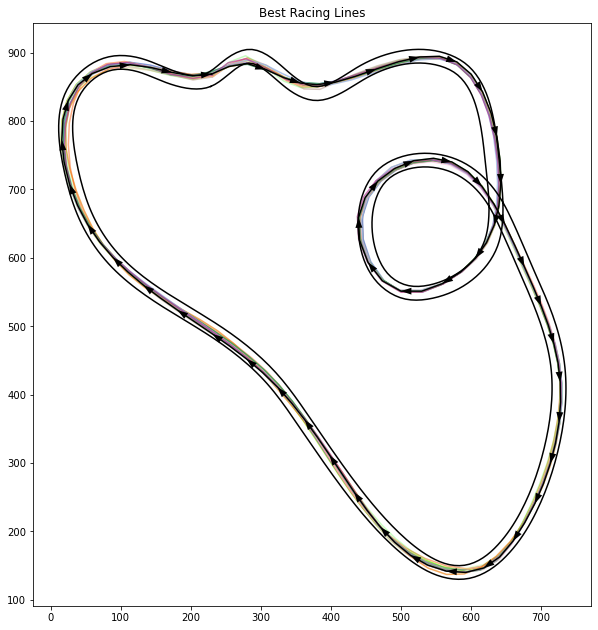

In [135]:
def racing_line_arrows(inx,iny):
    distx = 1
    if direction == 1:
        distx = -distx
    disty = distx
    
    for idx, x in enumerate(inx):
        if idx != 0 and idx % 2 == 0:
            plt.arrow(x, iny[idx], inx[idx+distx]-x, iny[idx+disty]-iny[idx], head_width=10,shape='full',color="black", lw=0, length_includes_head=True,zorder=2)

xa = best_line[0][0]
ya = best_line[0][1]

v = best_line[1]

figure_width = 10
ratio =  (abs(max(ynew))-abs(min(ynew))) / (abs(max(xnew))-abs(min(xnew)))
figure_height = figure_width * ratio
plt.rcParams["figure.figsize"] = (figure_width,figure_height)

fig, ax = plt.subplots()

for line in best_lines:
    ax.plot(line[0][0], line[0][1], c=np.random.rand(4,),zorder=1);
ax.plot(xa, ya, c="black")
ax.plot(*inner_track, color='black')
ax.plot(*outer_track,  color='black')
plt.title("Best Racing Lines")
racing_line_arrows(xa,ya)